In [1]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.applications import DenseNet121

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-05-11 16:55:11.502206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((64, 64))
image_size = 0
width=64
height=64
depth=3
image_size = 0
directory_root = 'Combined Data'

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :", e)
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
       
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Maize_Common_Rust ...
[INFO] Processing MLN ...
[INFO] Processing HEATHLY ...
[INFO] Processing MSV ...
[INFO] Processing Maize_Blight ...
[INFO] Processing Maize_Gray_Leaf_Spot ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
print(image_size)

6000


In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['HEATHLY' 'MLN' 'MSV' 'Maize_Blight' 'Maize_Common_Rust'
 'Maize_Gray_Leaf_Spot']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [8]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.20, random_state = 42)

[INFO] Spliting data to train, test


In [9]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [10]:
base_model = DenseNet121(
    weights='/Users/bhaumikpanchal/Downloads/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top=False, 
    input_shape=(64, 64, 3))

# Build model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(learning_rate=2e-5),
                      metrics=['acc', Precision(), Recall(), AUC(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2097664   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 9138246 (34.86 MB)
Trainable params: 9054598 (34.54 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [13]:
import time
start_time = time.time()
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)
end_time = time.time()
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/50
300/300 [==============================] - 348s 1s/step - loss: 1.5664 - acc: 0.4806 - precision: 0.5532 - recall: 0.3965 - auc: 0.8012 - true_positives: 1903.0000 - true_negatives: 22463.0000 - false_positives: 1537.0000 - false_negatives: 2897.0000 - val_loss: 0.7998 - val_acc: 0.7292 - val_precision: 0.7843 - val_recall: 0.6425 - val_auc: 0.9370 - val_true_positives: 771.0000 - val_true_negatives: 5788.0000 - val_false_positives: 212.0000 - val_false_negatives: 429.0000
Epoch 2/50
300/300 [==============================] - 369s 1s/step - loss: 0.8323 - acc: 0.7119 - precision: 0.7528 - recall: 0.6592 - auc: 0.9342 - true_positives: 3164.0000 - true_negatives: 22961.0000 - false_positives: 1039.0000 - false_negatives: 1636.0000 - val_loss: 0.5050 - val_acc: 0.8350 - val_precision: 0.8555 - val_recall: 0.8092 - val_auc: 0.9721 - val_true_positives: 971.0000 - val_true_negatives: 5836.0000 - val_false_positives: 164.0000 - val_false_negatives: 229.0000
Epoch 3/50
300/300 [==

Epoch 18/50
300/300 [==============================] - 348s 1s/step - loss: 0.1794 - acc: 0.9396 - precision: 0.9456 - recall: 0.9352 - auc: 0.9947 - true_positives: 4489.0000 - true_negatives: 23742.0000 - false_positives: 258.0000 - false_negatives: 311.0000 - val_loss: 0.2631 - val_acc: 0.9383 - val_precision: 0.9444 - val_recall: 0.9342 - val_auc: 0.9926 - val_true_positives: 1121.0000 - val_true_negatives: 5934.0000 - val_false_positives: 66.0000 - val_false_negatives: 79.0000
Epoch 19/50
300/300 [==============================] - 344s 1s/step - loss: 0.1871 - acc: 0.9396 - precision: 0.9435 - recall: 0.9354 - auc: 0.9940 - true_positives: 4490.0000 - true_negatives: 23731.0000 - false_positives: 269.0000 - false_negatives: 310.0000 - val_loss: 0.2524 - val_acc: 0.9408 - val_precision: 0.9502 - val_recall: 0.9383 - val_auc: 0.9931 - val_true_positives: 1126.0000 - val_true_negatives: 5941.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000
Epoch 20/50
300/300 [=====

Epoch 35/50
300/300 [==============================] - 354s 1s/step - loss: 0.1132 - acc: 0.9698 - precision: 0.9716 - recall: 0.9677 - auc: 0.9971 - true_positives: 4645.0000 - true_negatives: 23864.0000 - false_positives: 136.0000 - false_negatives: 155.0000 - val_loss: 0.2656 - val_acc: 0.9683 - val_precision: 0.9708 - val_recall: 0.9683 - val_auc: 0.9915 - val_true_positives: 1162.0000 - val_true_negatives: 5965.0000 - val_false_positives: 35.0000 - val_false_negatives: 38.0000
Epoch 36/50
300/300 [==============================] - 355s 1s/step - loss: 0.0928 - acc: 0.9698 - precision: 0.9712 - recall: 0.9683 - auc: 0.9982 - true_positives: 4648.0000 - true_negatives: 23862.0000 - false_positives: 138.0000 - false_negatives: 152.0000 - val_loss: 0.2372 - val_acc: 0.9658 - val_precision: 0.9666 - val_recall: 0.9650 - val_auc: 0.9929 - val_true_positives: 1158.0000 - val_true_negatives: 5960.0000 - val_false_positives: 40.0000 - val_false_negatives: 42.0000
Epoch 37/50
300/300 [=====

In [14]:
precision = history.history['precision'][-1]
recall = history.history['recall'][-1]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9829
Recall: 0.9821
F1 Score: 0.9825


In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Print the final accuracy values
print(f'Training Accuracy: {acc[-1]:.4f}')
print(f'Validation Accuracy: {val_acc[-1]:.4f}')




Training Accuracy: 0.9825
Validation Accuracy: 0.9650


In [16]:
# Print additional metrics for training
print(f"Precision: {history.history['precision'][-1]:.4f}")

print(f"Recall: {history.history['recall'][-1]:.4f}")
print(f"AUC: {history.history['auc'][-1]:.4f}")
print(f"True Positives: {history.history['true_positives'][-1]:.4f}")
print(f"True Negatives: {history.history['true_negatives'][-1]:.4f}")
print(f"False Positives: {history.history['false_positives'][-1]:.4f}")
print(f"False Negatives: {history.history['false_negatives'][-1]:.4f}")

Precision: 0.9829
Recall: 0.9821
AUC: 0.9985
True Positives: 4714.0000
True Negatives: 23918.0000
False Positives: 82.0000
False Negatives: 86.0000


In [17]:
# ... (previous code)

# Evaluate the model on the test set
test_metrics = model.evaluate(x_test, y_test)

# Extract individual metric values
test_loss, test_accuracy, precision, recall, auc, true_positives, true_negatives, false_positives, false_negatives = test_metrics

# Print the testing accuracy
print(f"Testing Accuracy: {test_accuracy:.4f}")


38/38 [==============================] - 14s 373ms/step - loss: 0.2590 - acc: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9908 - true_positives: 1158.0000 - true_negatives: 5958.0000 - false_positives: 42.0000 - false_negatives: 42.0000
Testing Accuracy: 0.9650


dict_keys(['loss', 'acc', 'precision', 'recall', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_auc', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives'])


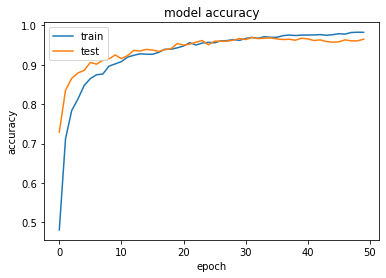

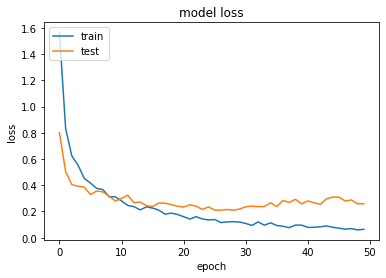

In [18]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

38/38 [==============================] - 16s 370ms/step


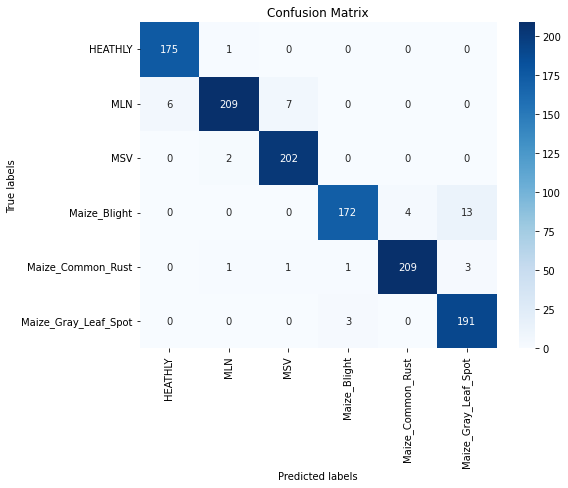

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicting the classes for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
model.save(f'./model/densenet_combined.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import os
[  os.listdir("./model")]

[['.DS_Store',
  'customCNN_combined.h5',
  '9',
  '7',
  '111',
  '6',
  '1',
  'densenet_combined.h5',
  'AlexNet_nb.h5',
  'vgg_combined.h5',
  'alexnet_combined.h5',
  'resnet50_combined.h5',
  'resnet50.h5',
  'vgg16_nb.h5',
  'mobilenet_combined.h5',
  'customcnn_nb.h5',
  '112',
  'MobieNet_nb.h5',
  '4',
  '3',
  '12',
  '2',
  '5']]

In [2]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model=load_model(f'./model/densenet_combined.h5')

2024-05-26 23:17:45.554868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
from sklearn.metrics import classification_report
import random

# Predicting the classes for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Get the class labels
class_labels = label_binarizer.classes_

# Generate a classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

# Select 1 random index from the test set
random_index = random.choice(range(len(y_test)))

# Print the actual and predicted labels for the selected test sample
print("Actual vs Predicted Labels for 1 Random Test Image")
print(f"Image {random_index+1}:")
print(f"  Actual: {class_labels[y_true_classes[random_index]]}")
print(f"  Predicted: {class_labels[y_pred_classes[random_index]]}")

# Optionally, display the image
plt.imshow(x_test[random_index])
plt.title(f"Actual: {class_labels[y_true_classes[random_index]]}, Predicted: {class_labels[y_pred_classes[random_index]]}")
plt.axis('off')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'model' is not defined